# B value vs Nea. ancestry using f4 ratios

In [1]:
n_bins <- 10

In [2]:
suppressPackageStartupMessages({

library(tidyverse)
library(admixr)

source("../code/utils.R")
source("../code/assign_bvals.R")

})

In [13]:
b <- read_tsv("../tmp/b.txt", col_names=c("chrom", "pos", "bval")) %>% mutate(chrom=paste0("chr", chrom)) %>% 
    mutate(bin=findInterval(bval, quantile(bval, seq(0, 1, 1 / n_bins), na.rm=TRUE), rightmost.closed=TRUE))

Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer(),
  bval = col_integer()
)


#### Read Big Yoruba sites

In [3]:
big_YRI <- read_snp("../data/eigenstrat/bigyri_ho/all_BigYRI.snp") %>% 
    filter(chrom %in% 1:22) %>% 
    mutate(chrom=paste0("chr", chrom), start=pos - 1, end=pos) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE) %>% 
    assign_bvals(bval_path="../data/bkgd/", chain_path="../data/hg18ToHg19.over.chain") %>%
    as.data.frame %>%
    select(chrom=seqnames, pos=end, bval) %>%
    mutate(bin=findInterval(bval, quantile(bval, seq(0, 1, 1 / n_bins), na.rm=TRUE), rightmost.closed=TRUE))

Warning message in inherits:
“closing unused connection 4 (../data/hg18ToHg19.over.chain)”

In [16]:
x <- inner_join(b, big_YRI, by=c("chrom", "pos"))

Warning message:
“Column `chrom` joining character vector and factor, coercing into character vector”

In [21]:
all(x$bval.x == x$bval.y, na.rm=T)

[1] TRUE

#### Read Human Origins sites

In [4]:
humorig <-  read_snp("../data/eigenstrat/bigyri_ho/all_HO.snp") %>% 
    filter(chrom %in% 1:22) %>% 
    mutate(chrom=paste0("chr", chrom), start=pos - 1, end=pos) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE) %>% 
    assign_bvals(bval_path="../data/bkgd/", chain_path="../data/hg18ToHg19.over.chain") %>%
    as.data.frame %>%
    select(chrom=seqnames, pos=end, bval) %>%
    mutate(bin=findInterval(bval, quantile(bval, seq(0, 1, 1 / n_bins), na.rm=TRUE), rightmost.closed=TRUE))

Warning message in if (!is(method, "MethodWithNext")) {:
“closing unused connection 4 (../data/hg18ToHg19.over.chain)”

#### Read 2.2M sites

In [5]:
twoM <-  read_snp("../data/eigenstrat/bigyri_ho/all.snp") %>% 
    filter(chrom %in% 1:22) %>% 
    mutate(chrom=paste0("chr", chrom), start=pos - 1, end=pos) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE) %>% 
    assign_bvals(bval_path="../data/bkgd/", chain_path="../data/hg18ToHg19.over.chain") %>%
    as.data.frame %>%
    select(chrom=seqnames, pos=end, bval) %>%
    mutate(bin=findInterval(bval, quantile(bval, seq(0, 1, 1 / n_bins), na.rm=TRUE), rightmost.closed=TRUE))

Warning message in .getMethodsTable(fdef, inherited = TRUE):
“closing unused connection 4 (../data/hg18ToHg19.over.chain)”

#### Read archaic admixture array sites

In [6]:
aa_sites <- read_tsv("../data/genotypes/ice_age.tsv") %>% 
    mutate(chrom=paste0("chr", chrom), start=pos - 1, end=pos) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE) %>% 
    assign_bvals(bval_path="../data/bkgd/", chain_path="../data/hg18ToHg19.over.chain") %>%
    as.data.frame

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Warning message in .getClassesFromCache(Class):
“closing unused connection 4 (../data/hg18ToHg19.over.chain)”

In [7]:
nrow(big_YRI)
nrow(humorig)
nrow(twoM)
nrow(aa_sites)

[1] 519434

[1] 1059687

[1] 1579121

[1] 945124

#### Read genome-wide B value regions

In [8]:
bval_files <- list.files("../data/bkgd/", full.names = TRUE, ".*.bkgd")
bval_df_list <- lapply(bval_files, function(filename) {
    read.table(filename, col.names = c("bval", "length")) %>% 
        mutate(chr = str_replace(basename(filename), ".bkgd", 
            ""), end = cumsum(length), start = c(1, (end + 
            1)[-n()])) %>% select(chr, start, end, bval)
})
bval_regions_hg18 <- bind_rows(bval_df_list)

In [9]:
bvals <- bind_rows(
    data.frame(bval=big_YRI$bval, sites="Big Yoruba"),
    data.frame(bval=humorig$bval, sites="Human Origins"),
    data.frame(bval=aa_sites$bval, sites="archaic admixture array"),
    data.frame(bval=bval_regions_hg18$bval, sites="genome-wide B values")
) %>% mutate(sites=factor(sites))

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

Warning message:
“Removed 252 rows containing non-finite values (stat_density).”

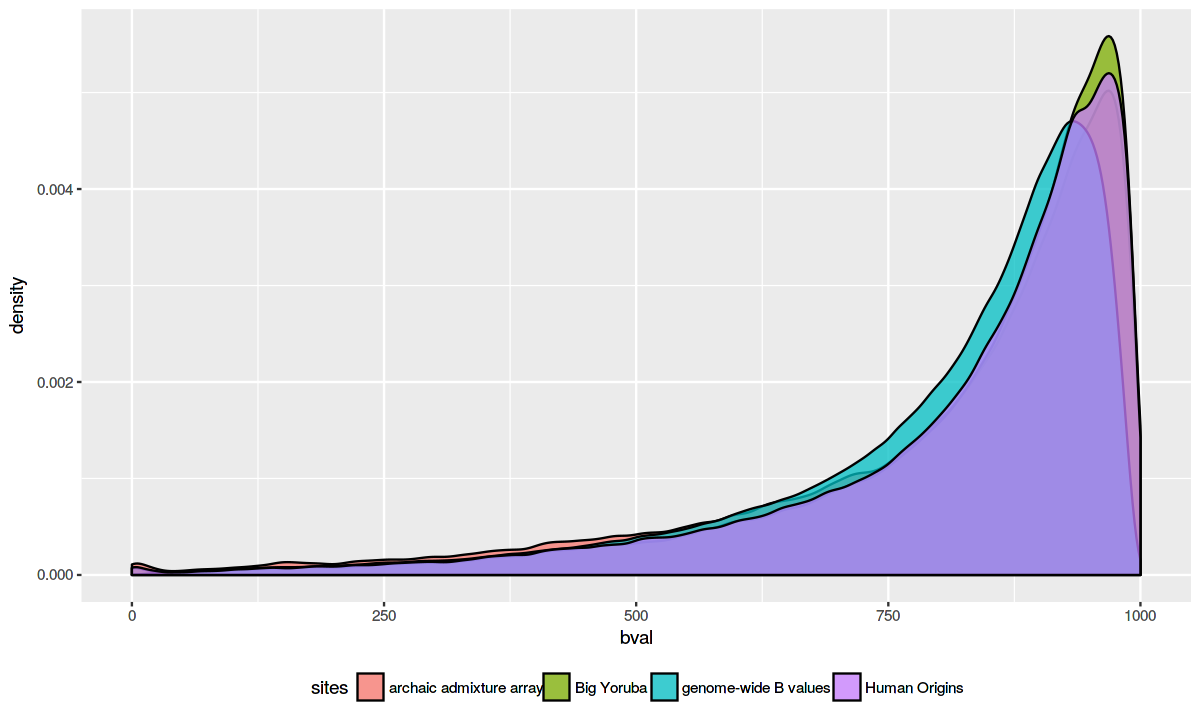

In [10]:
options(repr.plot.width=10, repr.plot.height=6)

ggplot(bvals, aes(bval, fill=sites)) +
    geom_density(alpha=0.75) +
    scale_colour_manual(values = c("red", "green", "blue")) + 
    theme(legend.position="bottom")

In [11]:
group_by(bvals, sites) %>% summarise(mean(bval, na.rm=TRUE), sd(bval, na.rm=TRUE), quantile(na.rm=TRUE, bval, probs=0.1))

sites,"mean(bval, na.rm = TRUE)","sd(bval, na.rm = TRUE)","quantile(na.rm = TRUE, bval, probs = 0.1)"
archaic admixture array,802.8912,196.8851,514
Big Yoruba,827.9272,175.2446,584
genome-wide B values,803.5139,172.9799,561
Human Origins,822.3005,178.5978,572


In [27]:
group_by(bvals, sites) %>% summarise(mean(bval, na.rm=TRUE), sd(bval, na.rm=TRUE), quantile(na.rm=TRUE, bval, probs=0.1))

sites,"mean(bval, na.rm = TRUE)","sd(bval, na.rm = TRUE)","quantile(na.rm = TRUE, bval, probs = 0.1)"
admixture array,802.8912,196.8851,514
big Yoruba + human origins,920.9962,102.0883,787
genome-wide B values,803.5139,172.9799,561


In [11]:
table(twoM$bin)


     1      2      3      4      5      6      7      8      9     10 
157274 157126 156293 160052 156154 159587 157992 151170 163998 159329 

In [90]:
table(f4_sites$bin)


    (0,100]   (100,200]   (200,300]   (300,400]   (400,500]   (500,600] 
          0           0         493        2324       10725       28619 
  (600,700]   (700,800]   (800,900] (900,1e+03] 
      64828      112023      259126     1466127 

In [12]:
library(admixr)
library(parallel)

In [13]:
source("../code/utils.R")
samples <- load_samples()
samples %<>% filter(!pop %in% c("Africa", "Oceania"))

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [14]:
bval_dir <- "../data/eigenstrat/bval/"

In [32]:
EIGENSTRAT_DIR <- "../data/eigenstrat/bigyri_ho/"
EIGENSTRAT_PREFIX <- paste0(EIGENSTRAT_DIR, "all_HO")

BVAL_EIGENSTRAT_PREFIX <- paste0(bval_dir, "all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "all.ind")

In [33]:
dir.create(bval_dir, showWarnings=FALSE)

Generate BED files for each bin:

In [34]:
for (bin_i in 1:n_bins) {
    bed_file <- file.path(bval_dir, paste0("bin_", bin_i, ".bed"))
    filter(humorig, bin == bin_i) %>%
        mutate(chrom=str_replace(chrom, "chr", ""), start=as.integer(pos - 1), end=as.integer(pos)) %>%
        select(chrom, start, end) %>% 
        write_tsv(path=bed_file, col_names=FALSE)
}

Generate EIGENSTRAT subsets for each bin:

In [35]:
mclapply(mc.cores=n_bins, 1:n_bins, function(bin_i) {
    bed_file <- file.path(bval_dir, paste0("bin_", bin_i, ".bed"))
    subset_sites(prefix=EIGENSTRAT_PREFIX, out_prefix=paste0(BVAL_EIGENSTRAT_PREFIX, "_", bin_i), bed_file=bed_file)
})

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

In [36]:
f4_bins<- mclapply(mc.cores=n_bins, 1:n_bins, function(bin_i) {
    bin_prefix <- paste0(BVAL_EIGENSTRAT_PREFIX, "_", bin_i)
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=bin_prefix) %>% mutate(bin=bin_i)
}) %>% bind_rows %>% mutate(bin=factor(bin)) %>% inner_join(samples, by=c("X"="name"))

In [30]:
options(repr.plot.width=9, repr.plot.height=5)

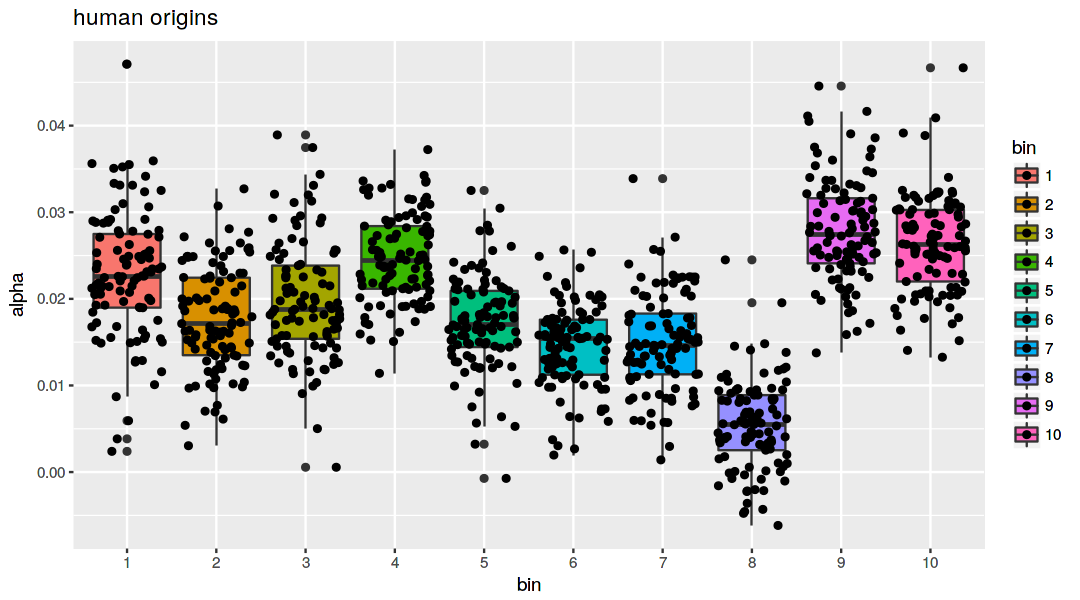

In [38]:
f4_bins %>% filter(pop != "EMH") %>% 
ggplot(aes(bin, alpha, fill=bin)) + geom_boxplot() + geom_jitter() + ggtitle("human origins")

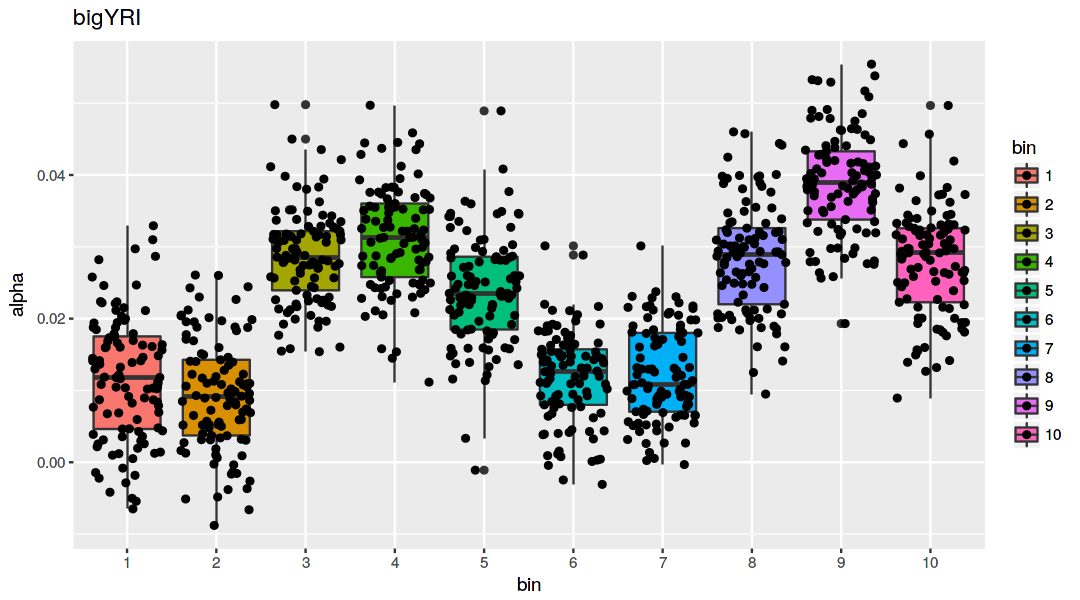

In [31]:
f4_bins %>% filter(pop != "EMH") %>% 
ggplot(aes(bin, alpha, fill=bin)) + geom_boxplot() + geom_jitter() + ggtitle("bigYRI")

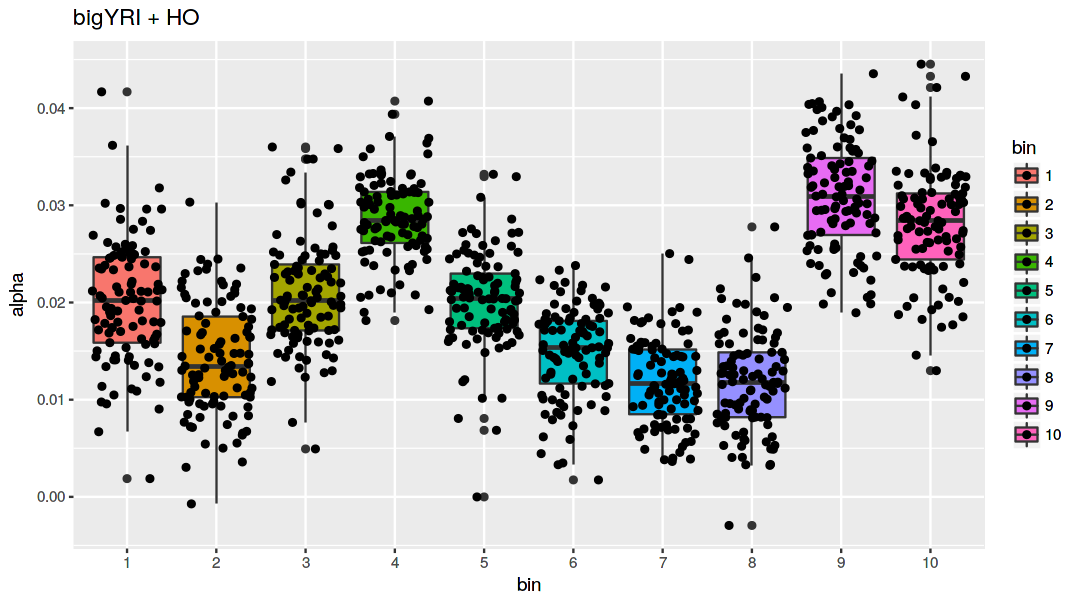

In [24]:
f4_bins %>% filter(pop != "EMH") %>% 
ggplot(aes(bin, alpha, fill=bin)) + geom_boxplot() + geom_jitter() + ggtitle("bigYRI + HO")